# Group Project Final Report
## Predicting Subscription Status of Players using K-NN Classification 
#### By: Stephen Weng, Amelia Hinton, Kristy Kwan

## Introduction

In this project, we are analyzing the `original_players` dataset collected by the Pacific Laboratory for Artificial Intelligence (PLAI). They have set up a Minecraft server that records players' actions to collect data to understand how people play video games. 

In [13]:
library(tidyverse)
original_players <- read_csv("players.csv")
head(original_players)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


The `original_players` dataset has 196 observations and 7 variables, each representing a unique player, their characteristics, playing hours, etc. 

#### Variables:
- `experience` - a player's experience level (categorical)
- `subscribe` - whether a player is subscribed to the newsletter (categorical)o
- `hashedEmail` - a player's partially masked email (categorical)
- `played_hours` - total hours played by the individual (numerical)
- `name` - player name (categorical)
- `gender` - player gender (categorical)
- `Age` - player age (numerical)

#### Issues:
- few variables such as `Age` contain NAs
- class imbalance in `subscribe`
- age and gender are self-reported -> may contain potential bias
- the "0"s in `played_hours` are ambiguous (may represent no activity, or rounded-down playing time for too short activity), data doesn't distinguish between these two cases
- no clarification of how the `experience` variable was calculated because some more experienced players have no hours played -> uncertain how experience was determined

In [38]:
mean_values <- original_players |>
            summarise(mean_hours = mean(played_hours, na.rm = TRUE),
                      mean_age = mean(Age, na.rm = TRUE))
mean_values
total_subscribers <- original_players |>
                filter(subscribe == "TRUE") |>
                summarise(count = n())
total_subscribers

mean_hours,mean_age
<dbl>,<dbl>
5.845918,21.13918


count
<int>
144


#### Summary Statistics:
- average played hours = 5.85 hours
- total subscribers = 144
- average age = age 21

The broad question we chose was Question 1: "What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?"

#### Specific Question: "Can an individual's playing hours and age predict whether they subscribe to a game-related newsletter?"

The response variable would be `subscribe`, and the predictors would be `played_hours` and `Age`. Understanding this relationship contributes to identifying which player characteristics are most strongly tied to participation outside of gameplay.

#### Wrangling Required:
- standardize variable names -> `Age` to `age`
- clean missing values
- change categorical variables such as gender, subscribe, and experience into factors

In [40]:
players <- original_players |>
            rename(age = Age) |>
            mutate(experience = as.factor(experience),
                   gender = as.factor(gender),
                   subscribe = as.factor(subscribe))
head(players)

experience,subscribe,hashedEmail,played_hours,name,gender,age
<fct>,<fct>,<chr>,<dbl>,<chr>,<fct>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


#### Exploratory Data Analysis and Visualization:

In [39]:
mean_values

mean_hours,mean_age
<dbl>,<dbl>
5.845918,21.13918


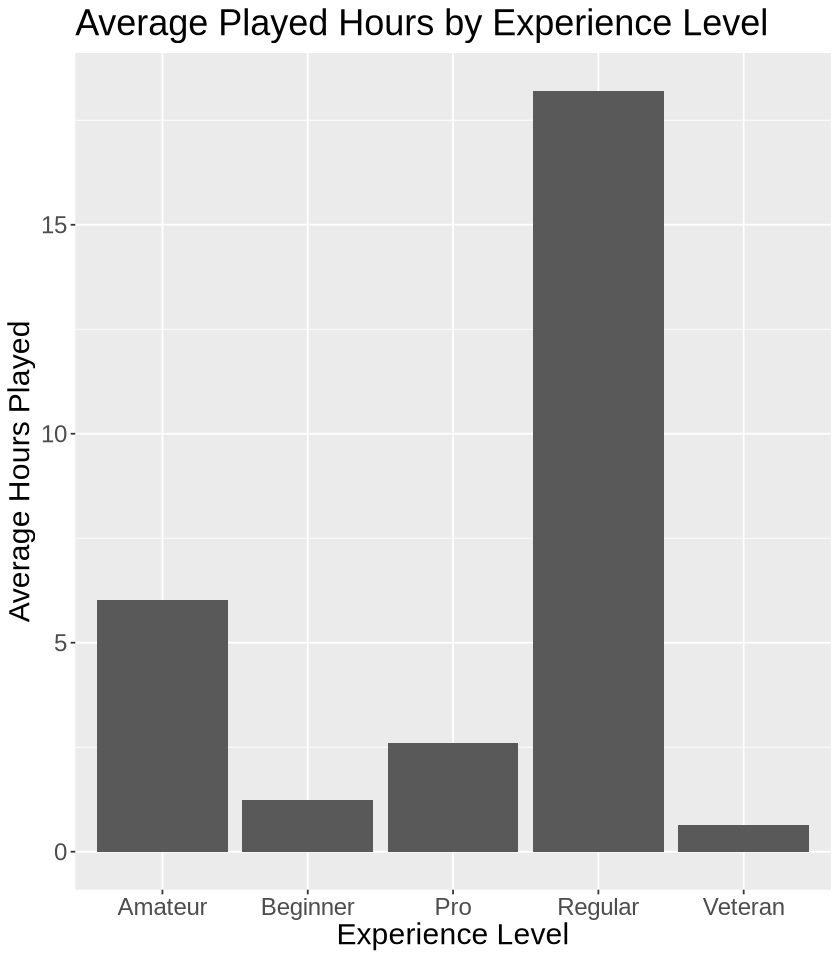

In [44]:
options(repr.plot.height = 8, repr.plot.height = 8)

experience_hours_summary <- players |>
            group_by(experience) |>
            summarise(mean_hours = mean(played_hours, na.rm = TRUE))
experience_hours_plot <- experience_hours_summary |>
                ggplot(aes(x = experience, y = mean_hours)) + 
                geom_bar(stat = "identity") + 
              labs(
                title = "Average Played Hours by Experience Level", 
                x = "Experience Level", 
                y = "Average Hours Played") + 
            theme(text = element_text(size = 18))
experience_hours_plot

The `experience_hours_plot` shows how average play time differs by experience level. We see that "regular" players show the highest average hours played, suggesting that experience level may be linked to game engagement, and potentially to subscription status. However, the uneven group sizes may affect the reliability of this pattern.

experience,avg_hours
<fct>,<dbl>
Amateur,8.2777778
Beginner,1.2703704
Pro,3.4100000
Regular,22.5965517
Veteran,0.7121212


experience,avg_hours
<fct>,<dbl>
Amateur,0.36666667
Beginner,1.17500000
Pro,0.57500000
Regular,0.02857143
Veteran,0.50666667


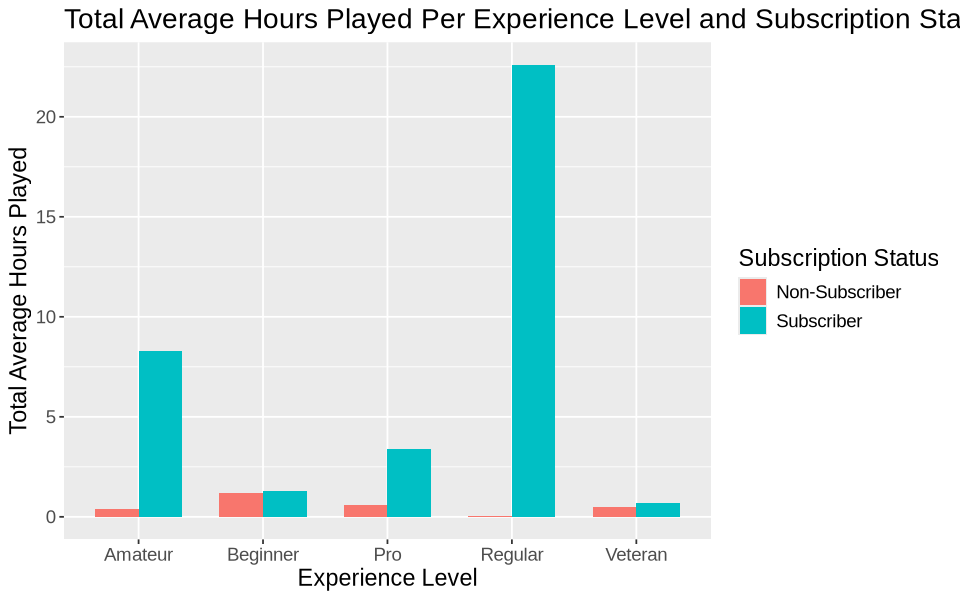

In [71]:
subscribers<- players|>
    filter(subscribe == TRUE) |> 
    group_by(experience)|>
    summarise(avg_hours = mean(played_hours, na.rm = TRUE)) 
non_subscribers<- players|>
    filter(subscribe == FALSE) |> 
    group_by(experience)|>
    summarise(avg_hours = mean(played_hours, na.rm = TRUE)) 
subscribers
non_subscribers

subscribers <- subscribers |> 
  mutate(subscribe = "Subscriber")

non_subscribers <- non_subscribers |> 
  mutate(subscribe = "Non-Subscriber")
players_combined<- bind_rows(subscribers, non_subscribers)

options(repr.plot.width = 8, repr.plot.height = 5)
subscribers_plot<- players_combined|>
    ggplot(aes(x= experience, y= avg_hours, fill = subscribe))+
    geom_col(position = "dodge", width = 0.7)+
    labs(x= "Experience Level", y= "Total Average Hours Played", fill = "Subscription Status")+ 
    ggtitle("Total Average Hours Played Per Experience Level and Subscription Status")+
    theme(text = element_text(size= 14))
subscribers_plot

The `subscribers_plot` demonstrates the difference in average play time between subscribers and non-subscribers across experience levels. We can observe a strong positive association between higher average playing time and the likelihood of subscribing, as demonstrated in the Amateur, Pro, and Regular experience levels.  However, this predictive relationship is weak for Beginner and Veteran players, where the average played hours are low and similar for both subscribers and non-subscribers. Overall, this visualization suggests that experience level and average playing hours are good predictors of subscription status.

In [72]:
Add another plot here:

ERROR: Error in parse(text = x, srcfile = src): <text>:1:5: unexpected symbol
1: Add another
        ^


## Methods & Results

To answer our specific question: "Can an individual's playing hours and age predict whether they subscribe to a game-related newsletter?", K-NN Classification will be used. 

#### K-NN is appropriate because: 
- task is to predict a categorical variable (subscription) from numerical predictor variables 
- needs few assumptions about what the data must look like
- suitable when relationships between variables are non-linear -> may be the case in this dataset
- predicts based on the outcomes of the most similar players
    - fits context because players with similar characteristics tend to have similar       subscription behavior

#### Assumptions:
- predictors must be on comparable scales (standardization) so one predictor variable is not favored over another

#### Limitations:
- slower with larger datasets
- struggle with noisy data
- performance depends heavily on the chosen value of K (prevent over/under fitting)

#### Data Processing Plan:
1. Split the whole dataset into training (75%) and testing (25%)
    -  stratify the data so there is an even distribution of subscribers and non-subscribers between the testing and training data
2. Standardize numeric predictors using training data only
3. Tune K using 5-fold cross-validation on the training set
    - limit over-/under-fitting -> ensuring accuracy of predictions
    - choose K with the highest estimated accuracy
5. Fit the final K-NN model using the best K
6. Evaluate classification accuracy on the test set

### Performing the Data Processing:

In [73]:
head(players)

experience,subscribe,hashedEmail,played_hours,name,gender,age
<fct>,<fct>,<chr>,<dbl>,<chr>,<fct>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


In [76]:
players_split <- initial_split(players, prop = 0.75, strata = subscribe)
players_train <- training(players_split)
players_test <- testing(players_split)

ERROR: Error in initial_split(players, prop = 0.75, strata = subscribe): could not find function "initial_split"
